In [23]:
#8.3.2 배치 정규화와 드롭아웃

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim

In [25]:
# 원하는 데이터셋 불러오는 과정
trainset = torchvision.datasets.FashionMNIST(root='../chap08/data/', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [26]:
# batch size 는 4개. 즉 4개씩 불러옴
batch_size = 4

In [27]:
# shuffle 해서 가져온 데이터를 섞어서 저장
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [28]:
# 하나씩 돌면서, image 와 label을 할당
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
3


In [29]:
# plotting 함수 
def imshow(img, title):    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [30]:
# 배치가 4개니, 하나씩 돌아가면서 plotting
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

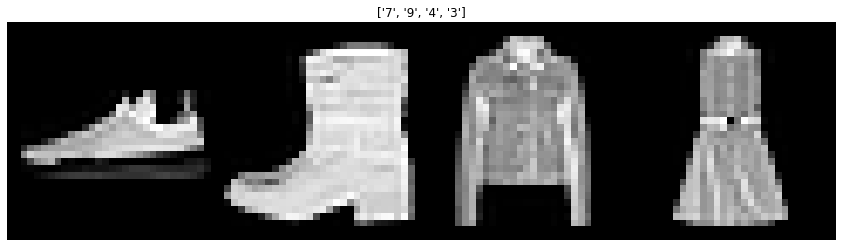

In [31]:
images, labels = show_batch_images(trainloader)

In [32]:
class NormalNet(nn.Module):
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            # linear -> Relu -> linear -> relu -> linear (final activation function)
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
    # 위에서 정의한 architecture를 정방향으로 흘러감.         
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [33]:
class BNNet(nn.Module):
    def __init__(self): 
        super(BNNet, self).__init__()
        # linear -> batch -> Relu -> linear -> batch -> Relu -> linear (final activation function)
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
    # 위에서 정의한 architecture를 정방향으로 흘러감.     
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [34]:
model = NormalNet()
print(model)
# Normalnet에 대한 각 층의 정보가 보임

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [35]:
model_bn = BNNet()
print(model_bn)
# BNNet 대한 각 층의 정보가 보임

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [36]:
# 이번엔 배치 사이즈를 512
batch_size = 512

In [37]:
# 512개의 train data를 섞어서 가져옴
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [38]:
# 학습을 위해, Loss & optimization 함수를 도입. (crossentropy , SGD)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

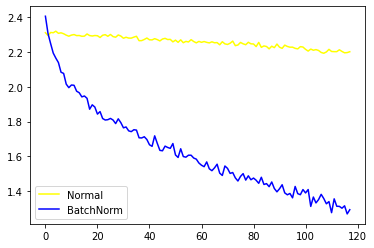

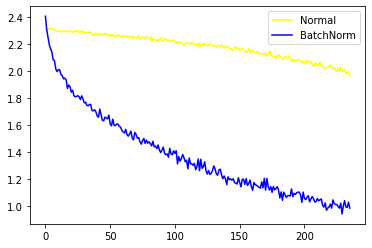

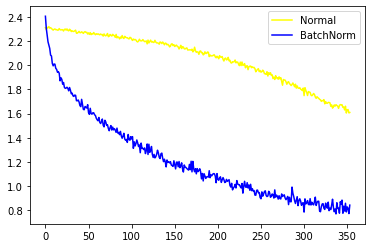

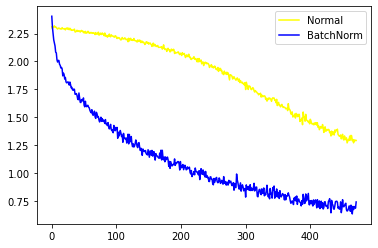

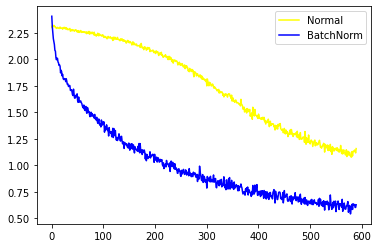

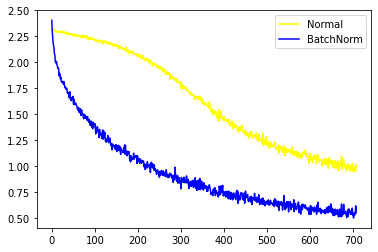

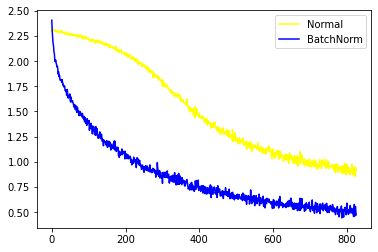

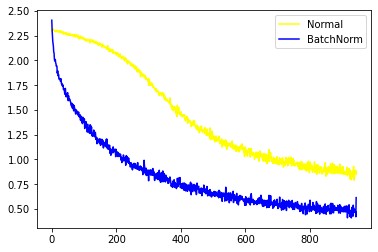

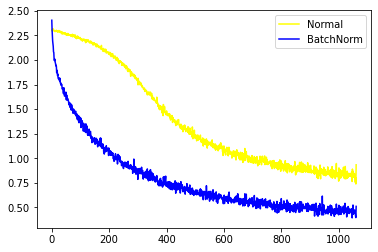

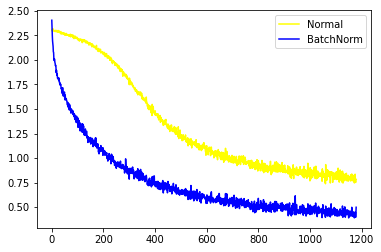

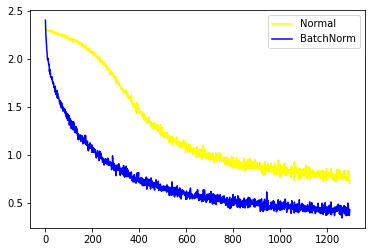

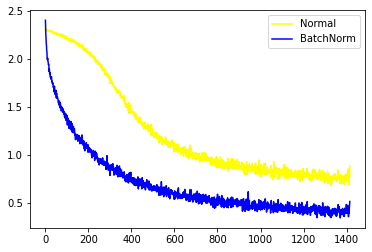

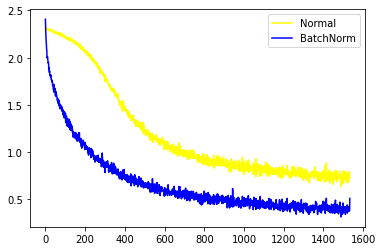

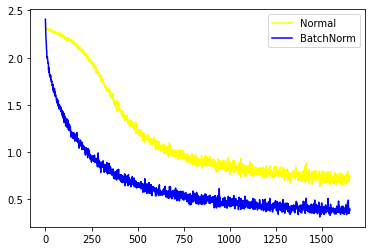

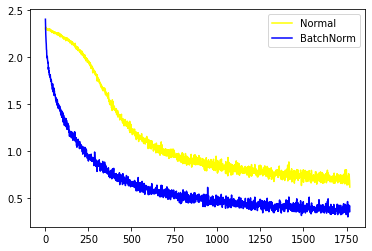

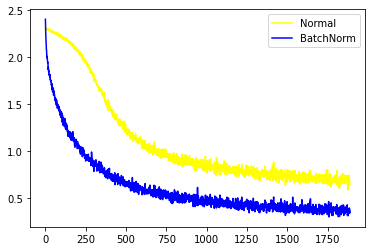

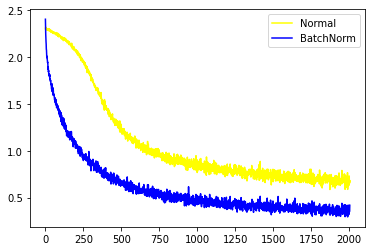

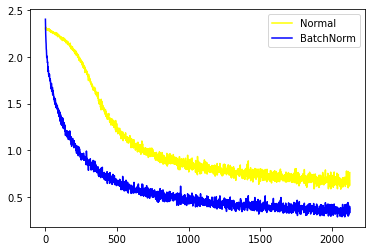

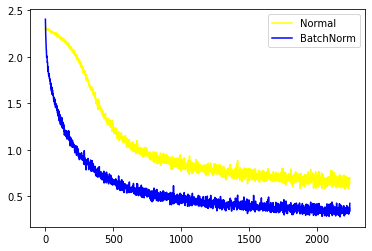

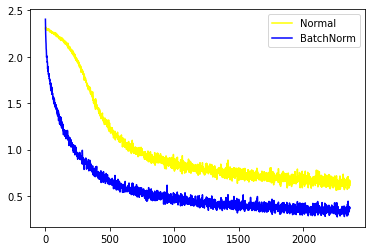

In [39]:
# 분석에 필요한 리스트
loss_arr = []
loss_bn_arr = []
max_epochs = 20

# 20번 반복
for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        #학습 -> loss -> optimization for model 1
        opt.zero_grad()
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        #학습 -> loss -> optimization for model 2
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()
    # 그리고 마지막 plotting

In [40]:
N = 50
noise = 0.3

# 임의로 데이터 생성.
x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

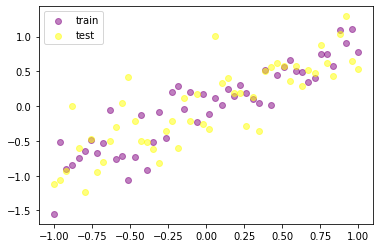

In [41]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [42]:
N_h = 100
model = torch.nn.Sequential(
    # linear -> Relu -> Linear -> Relu -> linear (final)
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    # linear -> dropout -> Relu -> Linear -> dropout -> Relu -> linear (final)
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [43]:
# 학습을 위한, optimization & loss function 도입 (Adam , loss)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

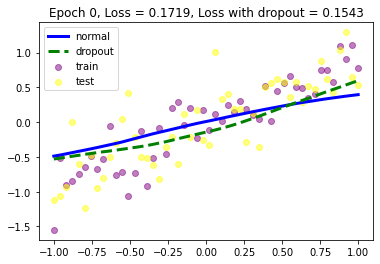

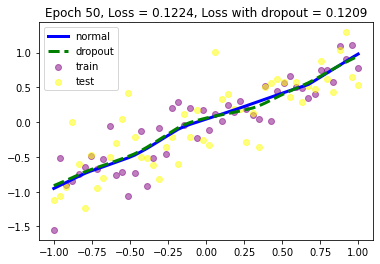

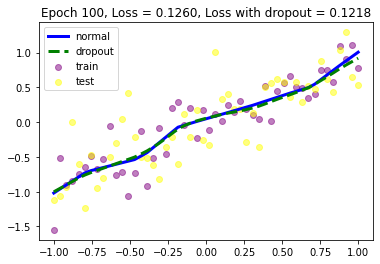

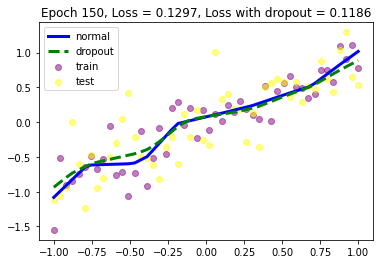

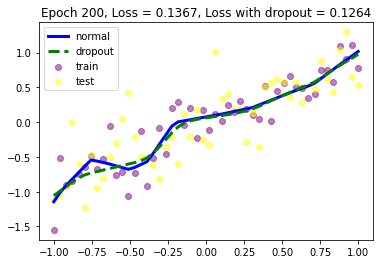

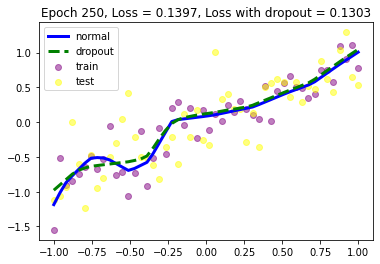

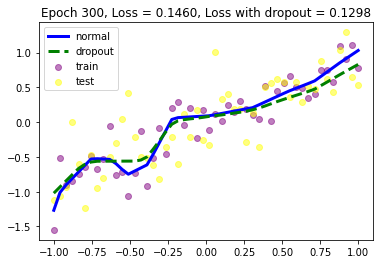

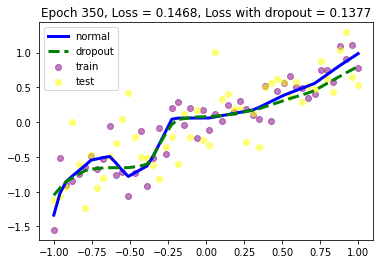

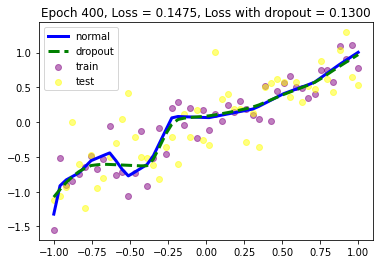

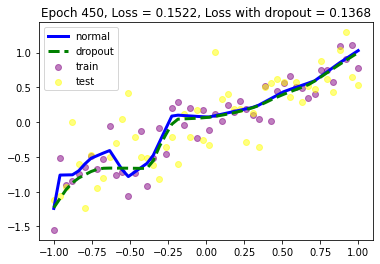

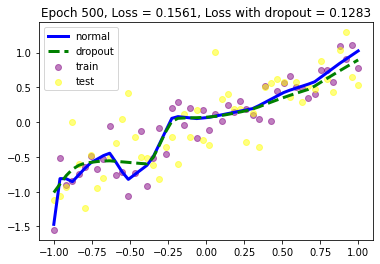

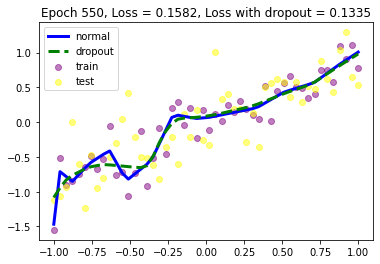

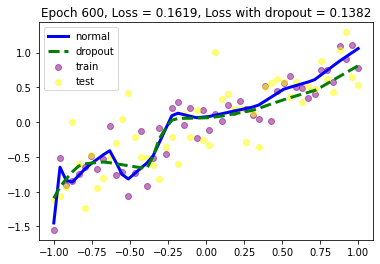

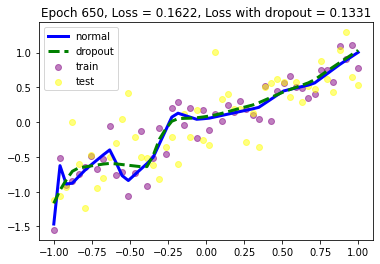

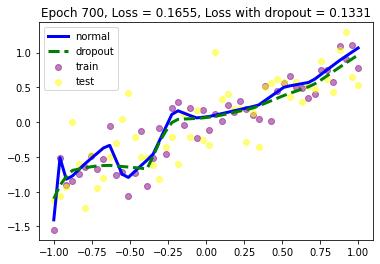

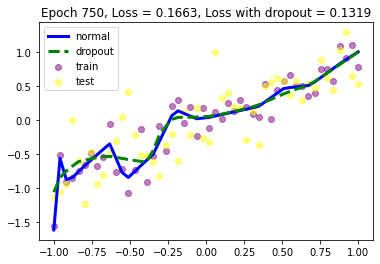

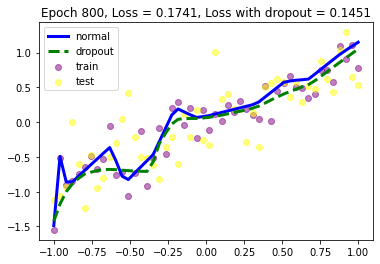

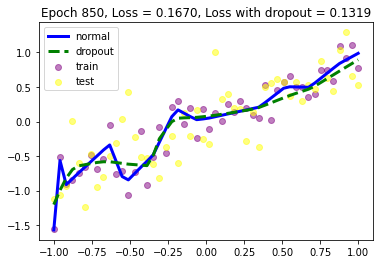

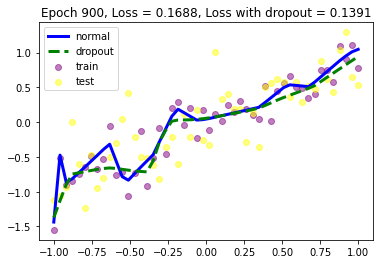

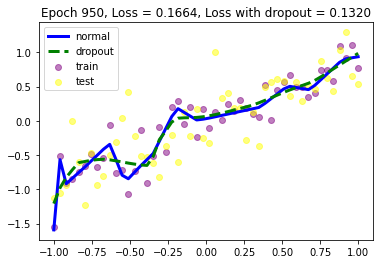

In [44]:
max_epochs = 1000

#1000번동안 진행
for epoch in range(max_epochs): 
    # predict -> loss -> optimization for model 1
    pred = model(x_train) 
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # predict -> loss -> optimization for model 2
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    # 50번의 학습 하는 동안, test sample의 결과 (정확도)를 비교
    if epoch % 50 == 0:        
        # test를 위해 eval로 바꿔줌
        model.eval()
        model_dropout.eval()
        
        #predict -> loss for model 1
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        #predict -> loss for model 2
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        # plotting and compare
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)